## Final Project for Supervised Learning
- https://github.com/KOBPHD/SupervisedLearningFinal/

### Project Topic
- **Data Overview**: For this project, I chose to examine a dataset (source: https://archive.ics.uci.edu/ml/datasets/Arrhythmia) of electrocardiogram features which includes expert (i.e. from a cardiologist) categorization as “healthy” (i.e. the absence of an arrhythmia) or as having an arrhythmia which is further categorized into one of 14 specific conditions for an unclassified arrhythmia. In addition to the expert classification, there are demographic characteristics, features directly extracted from the electrocardiogram recordings, and summary metrics calculated from the recordings.
- The hosts of this data request this citation information be included: Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.
- The raw data is a single flat table with 452 rows and 280 columns. While a few variables are encoded as binaries (e.g. patient sex, existence of ragged R/P/T waves, and existence of diphasic derivation of R/P/T waves), all other predictor variables are reported in the data documentation as “linear” and are continuous numeric variables. The classification variable is numerically encoded, but for “healthy” vs “arrhythmia” classification, this can be readily converted into a binary.
- **Topic Overview**: A short-duration electrocardiogram recording can be taken in a clinical environment with relatively low cost. There is a labor component for a trained technician, a small consumable cost (such as disposable electrodes), and the amortized cost of the electrocardiogram instrumentation, but the majority of the expense in routine cardiac screening is the labor cost for the physician. A classifier capable of identifying patients who warrant additional screening could expand the availability of routine electrocardiogram screenings and decrease both healthcare costs and labor burdens for general practitioners. I would like to see if this approach is feasible with a small dataset so that it could be examined in more detail with a larger dataset.
- **Model Plan**: Because this dataset has a large number of features relative to the total number of observations and the goal is classification along a binary (i.e. “healthy” vs “arrhythmia”) a support vector classifier would be a natural fit. I will leverage the grid-search technique we used in a previous homework problem to find good parameters for the classifier because it allows for quick searching of a broad range.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score

from scipy.stats import ttest_ind

from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
%matplotlib inline

The dataset is read in as a Pandas dataframe. It's CSV format even though it's a .data file extension. In the source file, missing data is encoded with a question mark, so this is replaced with a Numpy NaN for easier processing.

In [2]:
data = pd.read_csv("arrhythmia.data", sep=",", header=None)
data.replace("?", np.nan, inplace=True)
print(data.shape)

(452, 280)


### Data Cleaning
- Missing data was re-encoded (from "?" to Numpy NaN) for easier processing.
- More than 50% of the observations had missing data in the column for J-wave vector angle, so it was dropped. This is a feature of an electrocardiogram recording which is effectively absent in healthy patients (unless hypothermic) but is only found in a subset of pathologies, most of which were not featured in the encoded pathology state variable. Because continuous information about the wave amplitude is captured in another variable, dropping this seemed reasonable. An alternative approach could have been re-encoding presence or absence of the value as a binary, but there seemed to be more than enough variables in place already.
- Imputing missing observations would be problematic as many of these features are highly dependent upon other features, and imputing them would likely take expert input. Dropping rows with missing data does not seem to significantly bias the dataset in terms of demographic variables (see the scatter plot matrix below). Dropped patients are primarily either "normal", "ischemic changes (coronary heart disease)", "atrial fibrillation or flutter", or "others" (encoded as "1", "2", and "15", "16", respectively).
- *One major limitation of this approach to handling missing data is it entirely removes the "atrial fibrillation or flutter" category from the dataset, but automated methods of detecting atrial fibrillation are currently sufficiently mature to be incorporated into cardiac pacemakers and are presumably already automatically detected by most clinical-grade electrocardiogram units.*
- Dropping rows with missing data (after dropping the one mostly missing column) resulted in a loss of 32 observations (8 of which were "normal" patients) and left 420 observations for developing and testing the classifier models.

The column with mostly missing data is dropped entirely.

In [3]:
data.drop(data.columns[13],axis=1, inplace=True)

In [4]:
dropped_patients = data[data.isnull().any(axis = 1)].copy()
data.dropna(axis = 0, how = "any", inplace = True)

In [5]:
print(dropped_patients.shape)
print(data.shape)

(32, 279)
(420, 279)


array([[<AxesSubplot:xlabel='0', ylabel='0'>,
        <AxesSubplot:xlabel='2', ylabel='0'>,
        <AxesSubplot:xlabel='3', ylabel='0'>],
       [<AxesSubplot:xlabel='0', ylabel='2'>,
        <AxesSubplot:xlabel='2', ylabel='2'>,
        <AxesSubplot:xlabel='3', ylabel='2'>],
       [<AxesSubplot:xlabel='0', ylabel='3'>,
        <AxesSubplot:xlabel='2', ylabel='3'>,
        <AxesSubplot:xlabel='3', ylabel='3'>]], dtype=object)

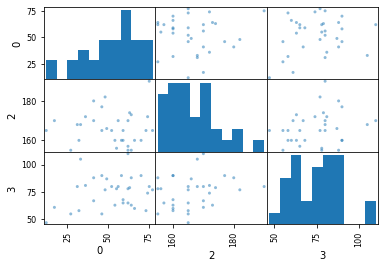

In [6]:
display(pd.plotting.scatter_matrix(dropped_patients.iloc[:,[0,2,3]]))

<AxesSubplot:>

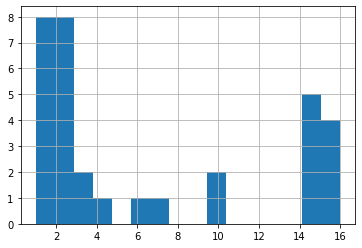

In [7]:
display(dropped_patients.iloc[:,-1].hist(bins = 16))

Re-encode pathology status as a binary where "0" is no-arrhythmia and "1" is any arrhythmia.
All data is set to numeric.

In [8]:
data.iloc[(data.iloc[:,-1] == 1), -1] = 0 #Re-encode "1" as "0" for no-arrhythmia
data.iloc[(data.iloc[:,-1] > 1), -1] = 1 #Re-encode "2"-"16" as "1" for arrhythmia

for col in range(data.shape[1]):
    data.iloc[:,col] = pd.to_numeric(data.iloc[:,col])

### Exploratory Data Analysis
- Because there are over 200 predictor variables, exploratory data analysis needs a quick filter to identify specific variables worth investigating.
- Data is split into healthy vs. arrhythmia and a t-test is performed for each variable with a Bonferroni correction for multiple comparisons. 33 variables show statistically significant differences in values between the two groups.
- *There are a prohibitively large number of variables even after that down-selection process to visualize, but the first 3 are included as examples because visualizations are a requirement in the rubric. In full disclosure, while I am strong advocate for early-stage visualization, for classification problems with very high-dimension data, exploratory data visualizations beyond checks regarding dropping data are generally semi-random guesses at what's worth visualizing, and if I were performing this analysis for my own applications rather than a class assignment, I wouldn't bother with them.*
- A cursory examination suggests that inter-correlation between extracted electrocardiogram features may be higher in the pathology group than in the control group, but no obvious segmentation boundaries appear in 2-dimensional space with the first four statistically significant variables being chosen.

In [9]:
t_cols = [i for i in range(0, data.shape[1]-2)]
for col in [1,20,21,22,23,24,25]: #Remove sex and the 6 binary wave characteristic columns
    t_cols.remove(col)

In [10]:
for col in t_cols:
    neg = data[data.iloc[:,-1] == 0].iloc[:,col].values.tolist()
    pos = data[data.iloc[:,-1] == 1].iloc[:,col].values.tolist()
    t_test = ttest_ind(neg, pos)
    if t_test[1] < (0.05 / (data.shape[1]-1)):
        print("Column:{}\tP-Value:{}".format(col, t_test[1]))

Column:4	P-Value:9.569450809124799e-13
Column:7	P-Value:7.559170293538317e-07
Column:28	P-Value:1.3214394831287964e-05
Column:51	P-Value:4.437547442017232e-05
Column:67	P-Value:0.00013370663098531552
Column:74	P-Value:0.00016161946962177747
Column:89	P-Value:1.306697855894896e-09
Column:91	P-Value:5.1673196323480644e-08
Column:98	P-Value:1.2084003892392197e-06
Column:101	P-Value:1.1573239023395973e-05
Column:110	P-Value:2.149656561753338e-06
Column:124	P-Value:5.128852429991491e-05
Column:134	P-Value:6.300420020369104e-05
Column:161	P-Value:8.48974713356094e-06
Column:165	P-Value:3.475912744492486e-10
Column:167	P-Value:2.7888320111324754e-10
Column:171	P-Value:4.606217066478099e-06
Column:175	P-Value:0.00010147662660366502
Column:177	P-Value:1.5727116138010548e-06
Column:190	P-Value:1.186081672987605e-05
Column:195	P-Value:7.297377175389309e-08
Column:197	P-Value:1.1466457881976484e-10
Column:205	P-Value:6.30786280993115e-07
Column:209	P-Value:1.3091800907850229e-05
Column:222	P-Value

array([[<AxesSubplot:xlabel='4', ylabel='4'>,
        <AxesSubplot:xlabel='7', ylabel='4'>,
        <AxesSubplot:xlabel='29', ylabel='4'>,
        <AxesSubplot:xlabel='52', ylabel='4'>],
       [<AxesSubplot:xlabel='4', ylabel='7'>,
        <AxesSubplot:xlabel='7', ylabel='7'>,
        <AxesSubplot:xlabel='29', ylabel='7'>,
        <AxesSubplot:xlabel='52', ylabel='7'>],
       [<AxesSubplot:xlabel='4', ylabel='29'>,
        <AxesSubplot:xlabel='7', ylabel='29'>,
        <AxesSubplot:xlabel='29', ylabel='29'>,
        <AxesSubplot:xlabel='52', ylabel='29'>],
       [<AxesSubplot:xlabel='4', ylabel='52'>,
        <AxesSubplot:xlabel='7', ylabel='52'>,
        <AxesSubplot:xlabel='29', ylabel='52'>,
        <AxesSubplot:xlabel='52', ylabel='52'>]], dtype=object)

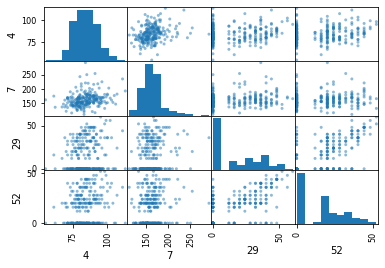

In [11]:
display(pd.plotting.scatter_matrix(data[data.iloc[:,-1] == 0].iloc[:,[4,7,28,51]]))

array([[<AxesSubplot:xlabel='4', ylabel='4'>,
        <AxesSubplot:xlabel='7', ylabel='4'>,
        <AxesSubplot:xlabel='29', ylabel='4'>,
        <AxesSubplot:xlabel='52', ylabel='4'>],
       [<AxesSubplot:xlabel='4', ylabel='7'>,
        <AxesSubplot:xlabel='7', ylabel='7'>,
        <AxesSubplot:xlabel='29', ylabel='7'>,
        <AxesSubplot:xlabel='52', ylabel='7'>],
       [<AxesSubplot:xlabel='4', ylabel='29'>,
        <AxesSubplot:xlabel='7', ylabel='29'>,
        <AxesSubplot:xlabel='29', ylabel='29'>,
        <AxesSubplot:xlabel='52', ylabel='29'>],
       [<AxesSubplot:xlabel='4', ylabel='52'>,
        <AxesSubplot:xlabel='7', ylabel='52'>,
        <AxesSubplot:xlabel='29', ylabel='52'>,
        <AxesSubplot:xlabel='52', ylabel='52'>]], dtype=object)

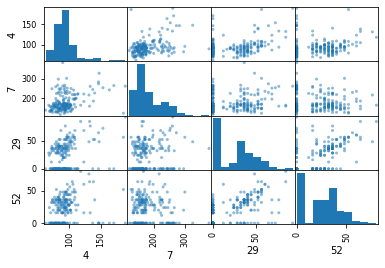

In [12]:
display(pd.plotting.scatter_matrix(data[data.iloc[:,-1] == 1].iloc[:,[4,7,28,51]]))

### Modeling
- Data was split into healthy and pathology (i.e. arrhythmia) groups, then each was split into training and test data. This was eventually coded as "neg" (healthy) and "pos" (arrhythmia) for brevity of code.
- A 75/25 split of training and testing data was created along with rand_state which is used to make multiple-runs of the model consistent (otherwise it's prohibitively difficult to document results in detail).
- The healthy and pathology data were split separately to ensure proportional representation between the two groups was consistent between training and testing.
- This data is essentially guaranteed to have collinearity because some features are derivatives of other features, but this should be of little to no impact on a support vector classifier.
- Three kernels ("rbf", "poly", and "sigmoid") were tested along with a wide array of values for the gamma and C parameters. (Note: These ranges were down-selected from a wider range at lower initial increment resolution to reduce run-time, but are not included to minimize code bloat.) 5-fold cross validation was used.
- For each kernel, the best-fit model from the gridsearch was used to determine an accuracy score and generate a reciever operating curve (and calculate the area under the curve for the ROC).

In [13]:
healthy_np = data[data.iloc[:,-1] == 0].to_numpy()
pathology_np = data[data.iloc[:,-1] == 1].to_numpy()

In [14]:
train_prop = 0.75
test_prop = 1.0 - train_prop
rand_state = 0

In [15]:
neg_np_X = healthy_np[:,0:-1]
neg_np_y = healthy_np[:,-1]
pos_np_X = pathology_np[:,0:-1]
pos_np_y = pathology_np[:,-1]

In [16]:
neg_np_X_train, neg_np_X_test, neg_np_y_train, neg_np_y_test = train_test_split(
    neg_np_X, neg_np_y, test_size = test_prop, random_state = rand_state)
pos_np_X_train, pos_np_X_test, pos_np_y_train, pos_np_y_test = train_test_split(
    pos_np_X, pos_np_y, test_size = test_prop, random_state = rand_state)

In [17]:
X_train = np.concatenate((neg_np_X_train, pos_np_X_train))
y_train = np.concatenate((neg_np_y_train, pos_np_y_train))
y_train = y_train.astype("int")
X_test = np.concatenate((neg_np_X_test, pos_np_X_test))
y_test = np.concatenate((neg_np_y_test, pos_np_y_test))
y_test = y_test.astype("int")

In [18]:
res = 2
gamma_vals = np.array([10**(i/res) for i in range(-(6*res),(0*res)+1,1)])
c_vals = np.array([10**(i/res) for i in range(-(6*res),(6*res)+1,1)])
grid_dict = {"gamma": gamma_vals, "C": c_vals}
K_folds = 5
grid_rbf = GridSearchCV(SVC(kernel = "rbf", probability=True), param_grid = grid_dict, cv = K_folds, refit=True)
grid_poly = GridSearchCV(SVC(kernel = "poly", probability=True), param_grid = grid_dict, cv = K_folds, refit=True)
grid_sigmoid = GridSearchCV(SVC(kernel = "sigmoid", probability=True), param_grid = grid_dict, cv = K_folds, refit=True)
grid_rbf.fit(X_train,y_train)
print("grid_rbf done")
grid_poly.fit(X_train,y_train)
print("grid_poly done")
grid_sigmoid.fit(X_train,y_train)
print("grid_sigmoid done")

grid_rbf done
grid_poly done
grid_sigmoid done


In [19]:
print(f"grid_rbf.best_estimator_:{grid_rbf.best_estimator_}")
print(f"grid_rbf.best_score_:{grid_rbf.best_score_}")
print(f"grid_rbf.best_params_:{grid_rbf.best_params_}")
print()
print(f"grid_poly.best_estimator_:{grid_poly.best_estimator_}")
print(f"grid_poly.best_score_:{grid_poly.best_score_}")
print(f"grid_poly.best_params_:{grid_poly.best_params_}")
print()
print(f"grid_sigmoid.best_estimator_:{grid_sigmoid.best_estimator_}")
print(f"grid_sigmoid.best_score_:{grid_sigmoid.best_score_}")
print(f"grid_sigmoid.best_params_:{grid_sigmoid.best_params_}")
print()

grid_rbf.best_estimator_:SVC(C=3.1622776601683795, gamma=1e-05, probability=True)
grid_rbf.best_score_:0.7581669226830517
grid_rbf.best_params_:{'C': 3.1622776601683795, 'gamma': 1e-05}

grid_poly.best_estimator_:SVC(C=1e-05, gamma=0.00031622776601683794, kernel='poly', probability=True)
grid_poly.best_score_:0.7517153097798259
grid_poly.best_params_:{'C': 1e-05, 'gamma': 0.00031622776601683794}

grid_sigmoid.best_estimator_:SVC(C=100.0, gamma=1e-06, kernel='sigmoid', probability=True)
grid_sigmoid.best_score_:0.7548387096774194
grid_sigmoid.best_params_:{'C': 100.0, 'gamma': 1e-06}



In [20]:
print("{} accuracy: {}".format("rbf",accuracy_score(y_test, grid_rbf.predict(X_test))))
print("{} accuracy: {}".format("poly",accuracy_score(y_test, grid_poly.predict(X_test))))
print("{} accuracy: {}".format("sigmoid",accuracy_score(y_test, grid_sigmoid.predict(X_test))))

rbf accuracy: 0.7830188679245284
poly accuracy: 0.7924528301886793
sigmoid accuracy: 0.7735849056603774


Citation: The ROC visualizaiton code below is adapted from the sklearn documentation page here: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

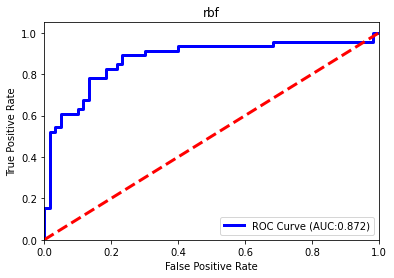

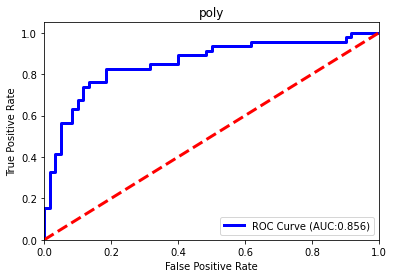

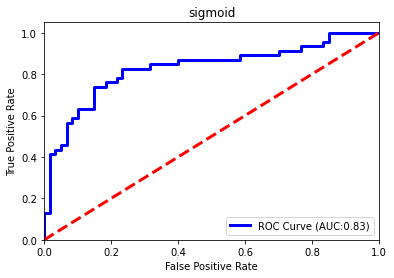

In [21]:
models = [grid_rbf, grid_poly, grid_sigmoid]
model_labels = ["rbf", "poly", "sigmoid"]
for m in range(3):
    fpr, tpr, _ = roc_curve(y_test, models[m].predict_proba(X_test)[:,1])
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color = "blue", lw = 3, label = "ROC Curve (AUC:{})".format(round(roc_auc,3)))
    plt.plot([0,1],[0,1], color = "red", lw = 3, linestyle = "--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("{}".format(model_labels[m]))
    plt.legend(loc="lower right")
    plt.show()

### Results, Discussion, and Conclusion
- All three kernel types showed approximately equal maximum accuracy and similar areas under the receiver operating curves.
- Accuracy is of general interest and, for a potential first-pass clinical screening tool, the false positive rate is an important metric. (Note: None of these models should be used for making medical decisions, and at most, this effort shows that machine learning techniques may help better allocate limited time and/or money resources in routine cardiac screening.)
- While the 77-79% accuracy for the best models is potentially useful, this still leaves substantial room for improvement.
- A broad limitation of any effort to train an skilled classifier based on extracted electrocardiogram features and expert classification is innaccuracy in either feature extraction or the training expert classification. Cardiologists show approximately 75% accuracy in classification from electrocardigram recordings (**Citation: Cook, D. A., Oh, S. Y., & Pusic, M. V. (2020). Accuracy of physicians’ electrocardiogram interpretations: a systematic review and meta-analysis. JAMA internal medicine, 180(11), 1461-1471.**), so this may ultimately require a different approach to data collection and feature extraction than current practices.
- This dataset was too small for developing a classifier for each pathology present in the set, but considering the age of this data, there is likely a larger and more suitable dataset available elsewhere.
- It is possible that other data sources (such a blood-test results and echocardiogram assessments) may provide accuracy improvements beyond any effective ceiling for electrocaridogram recordings, or higher temporal or voltage resolution electrocardiogram systems may also eleveate maximum accuracy, and further research in this area is definitely warranted.